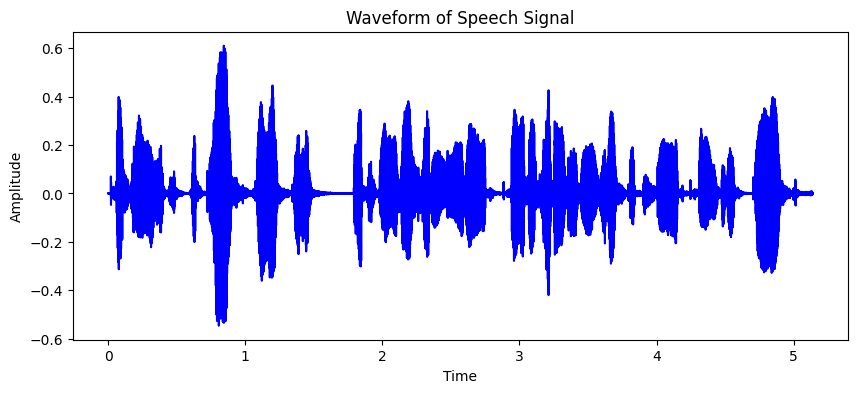

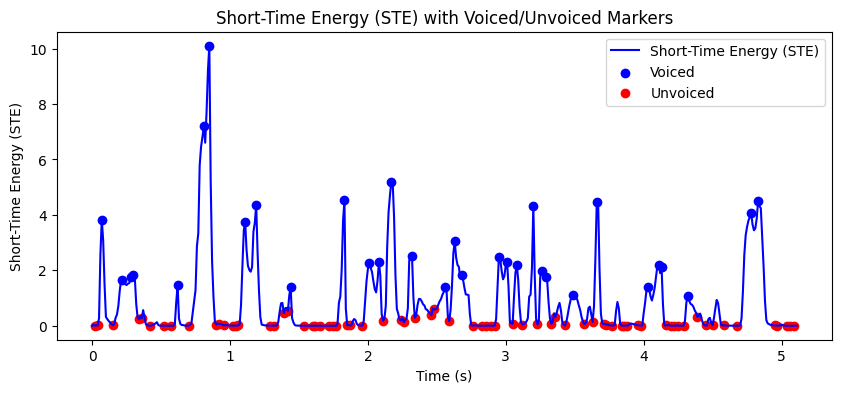

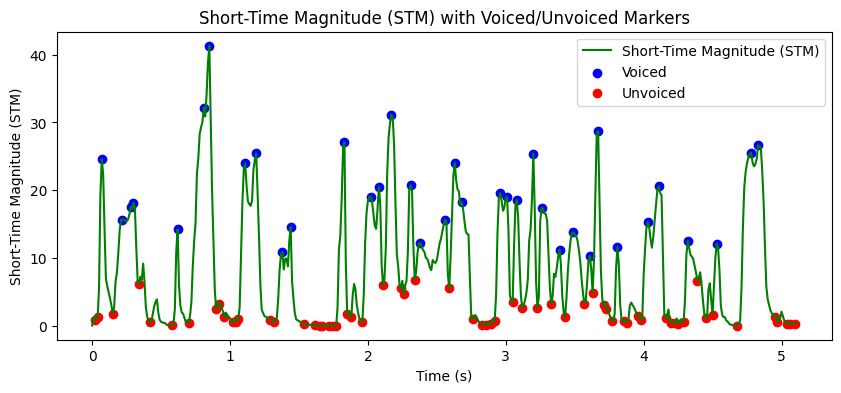

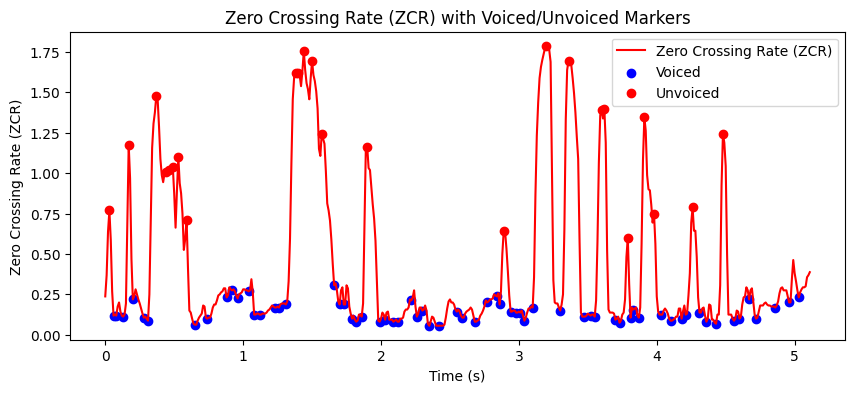

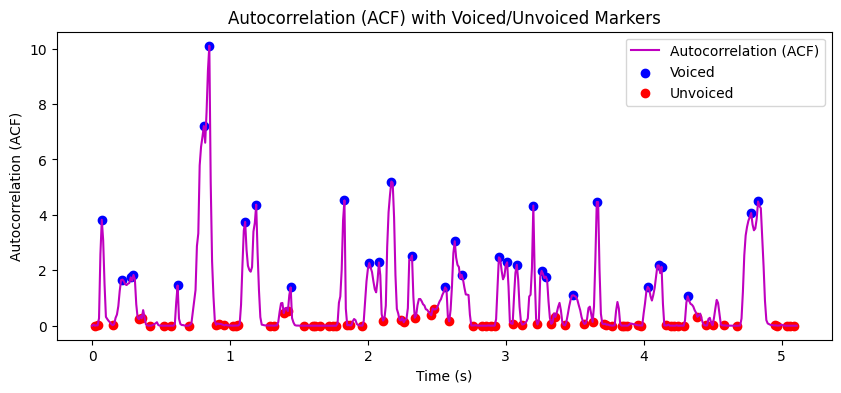

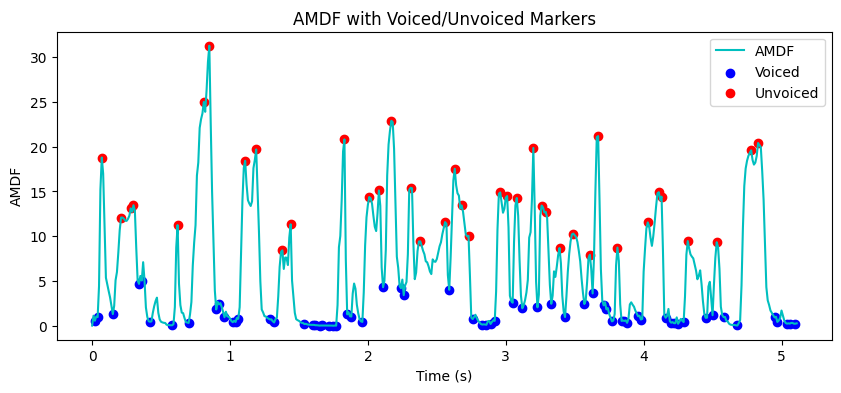

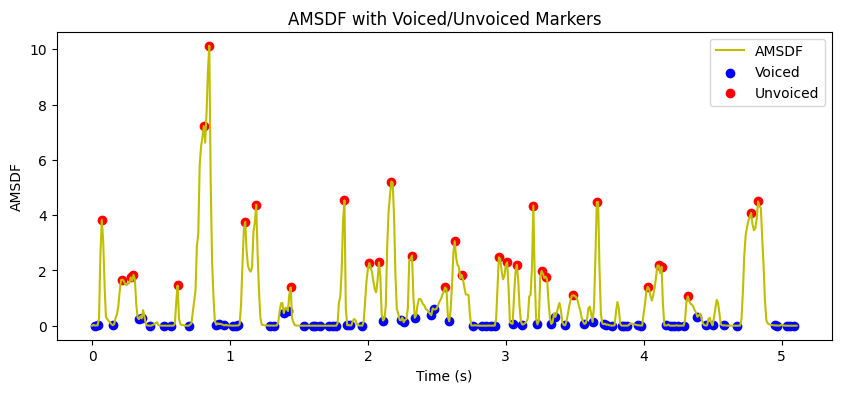

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import librosa
import scipy.signal
from scipy.signal import find_peaks

# Loading the audio file
audio, sr = librosa.load("/content/LJ001-0004.wav",sr=16000)
samples = len(audio)
dur = len(audio)/sr

# Plotting the wave form
time = np.linspace(0,dur,samples)
plt.figure(figsize=(10, 4))
plt.plot(time,audio, color='blue')
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Waveform of Speech Signal")
plt.show()

# Feature extraction functions
def short_time_energy(frame):
    return np.sum(frame ** 2)

def short_time_magnitude(frame):
    return np.sum(np.abs(frame))

def zero_crossing_rate(frame):
    return np.sum(np.abs(np.diff(np.sign(frame)))) / len(frame)

def autocorrelation(frame):
    return np.correlate(frame, frame, mode='full')[len(frame) - 1:]

def amdf(frame):
    frame_length = len(frame)
    return np.array([np.sum(np.abs(frame[:frame_length-k] - frame[k:])) for k in range(1, frame_length)])

def amsdf(frame):
    frame_length = len(frame)
    return np.array([np.sum((frame[:frame_length-k] - frame[k:]) ** 2) for k in range(1, frame_length)])

# Creating Hamming window
frame_size = int(0.02 * sr)
hop_size = int(0.01 * sr)
hamming_window = np.hamming(frame_size)

# Process the time-domain features
ste, stm, zcr, acf, amdf_val, amsdf_val = [], [], [], [], [], []
time_axis = []

for i in range(0, len(audio) - frame_size, hop_size):
    frame = audio[i:i + frame_size] * hamming_window
    time_axis.append(i / sr)

    ste.append(short_time_energy(frame))
    stm.append(short_time_magnitude(frame))
    zcr.append(zero_crossing_rate(frame))
    acf.append(autocorrelation(frame)[0])
    amdf_val.append(np.mean(amdf(frame)))
    amsdf_val.append(np.mean(amsdf(frame)))

# Identify voiced and unvoiced for each feature
def get_peaks_and_valleys(feature):
    peaks, _ = find_peaks(feature, height=np.mean(feature) * 1.2)
    valleys, _ = find_peaks(-np.array(feature), height=-np.mean(feature) * 0.8)
    return peaks, valleys

def get_peaks_and_valleys_corrected(feature):
    peaks, _ = find_peaks(-np.array(feature), height=-np.mean(feature) * 0.8)
    valleys, _ = find_peaks(feature, height=np.mean(feature) * 1.2)
    return peaks, valleys

ste_peaks, ste_valleys = get_peaks_and_valleys(ste)
stm_peaks, stm_valleys = get_peaks_and_valleys(stm)
zcr_peaks, zcr_valleys = get_peaks_and_valleys_corrected(zcr)
acf_peaks, acf_valleys = get_peaks_and_valleys(acf)
amdf_peaks, amdf_valleys = get_peaks_and_valleys_corrected(amdf_val)
amsdf_peaks, amsdf_valleys = get_peaks_and_valleys_corrected(amsdf_val)


# Plotting the features
def plot_feature(time_axis, feature, peaks, valleys, title, color):
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, feature, label=title, color=color)

    plt.scatter(np.array(time_axis)[peaks], np.array(feature)[peaks], color='blue', marker='o', label="Voiced")
    plt.scatter(np.array(time_axis)[valleys], np.array(feature)[valleys], color='red', marker='o', label="Unvoiced")

    plt.ylabel(title)
    plt.xlabel("Time (s)")
    plt.legend()
    plt.title(f"{title} with Voiced/Unvoiced Markers")

    plt.show()

plot_feature(time_axis, ste, ste_peaks, ste_valleys, "Short-Time Energy (STE)", 'b')
plot_feature(time_axis, stm, stm_peaks, stm_valleys, "Short-Time Magnitude (STM)", 'g')
plot_feature(time_axis, zcr, zcr_peaks, zcr_valleys, "Zero Crossing Rate (ZCR)", 'r')
plot_feature(time_axis, acf, acf_peaks, acf_valleys, "Autocorrelation (ACF)", 'm')
plot_feature(time_axis, amdf_val, amdf_peaks, amdf_valleys, "AMDF", 'c')
plot_feature(time_axis, amsdf_val, amsdf_peaks, amsdf_valleys, "AMSDF", 'y')